In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import preprocessing

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

import pickle

import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
tf.compat.v1.enable_eager_execution()
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Embedding, Dot, Concatenate, Add, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [24]:
user_health = preprocessing.load_users_health()
food_pref = preprocessing.load_food_pref_dataset()

In [25]:
user_health.head()

,seqn,weight,height,bmi,upper_leg_length,upper_arm_length,arm_circumference,waist_circumference,hip_circumference,systolic,diastolic,pulse
0,109264.0,42.2,154.7,17.6,36.3,33.8,22.7,63.8,85.000000,108.000000,67.000000,93.333333
1,109266.0,97.1,160.2,37.8,40.8,34.7,35.8,117.9,126.100000,99.000000,54.333333,66.666667
2,109270.0,75.3,156.0,30.9,42.6,36.1,31.0,91.4,105.696877,124.666667,73.333333,95.333333
3,109271.0,98.8,182.3,29.7,40.1,42.0,38.2,120.4,108.200000,107.000000,67.000000,71.333333
4,109273.0,74.3,184.2,21.9,41.0,41.1,30.2,86.8,94.500000,113.666667,67.333333,70.333333


In [64]:
x = user_health.set_index('seqn')
x.loc[124400.0]

weight                 162.900000
height                 157.300000
bmi                     65.800000
upper_leg_length        38.745666
upper_arm_length        40.100000
arm_circumference       53.300000
waist_circumference    124.200000
hip_circumference      157.800000
systolic               114.333333
diastolic               71.000000
pulse                   71.893791
Name: 124400.0, dtype: float64

In [26]:
food_pref.head()

,seqn,intake_day_of_week,name_of_eating_occasion,source_of_food,location_of_food_home,usda_food_code,grams,energy_kcal,protein_gm,carbohydrate_gm,...,pfa_eicosadienoic_gm,pfa_eicosatrienoic_gm,pfa_docosapentaenoic_gm,pfa_docosahexaenoic_gm,Food code,Main food description,WWEIA Category number,WWEIA Category description,Start date,End date
0,109263,Friday,Dinner,Store - grocery/supermarket,Yes,28320300,199.50,114.0,12.11,5.07,...,0.012,5.397605e-79,5.397605e-79,5.397605e-79,28320300,"Pork with vegetable excluding carrots, broccol...",3802,Soups,2019-01-01,2020-12-31
1,112171,Saturday,Dinner,Grown or caught by you or someone you know,Yes,28320300,299.25,172.0,18.08,8.32,...,0.018,5.397605e-79,5.397605e-79,5.397605e-79,28320300,"Pork with vegetable excluding carrots, broccol...",3802,Soups,2019-01-01,2020-12-31
2,112586,Saturday,Lunch,From someone else/gift,Yes,28320300,199.51,114.0,12.11,5.07,...,0.012,5.397605e-79,5.397605e-79,5.397605e-79,28320300,"Pork with vegetable excluding carrots, broccol...",3802,Soups,2019-01-01,2020-12-31
3,112670,Sunday,Dinner,Store - grocery/supermarket,Yes,28320300,128.25,74.0,7.75,3.56,...,0.008,5.397605e-79,5.397605e-79,5.397605e-79,28320300,"Pork with vegetable excluding carrots, broccol...",3802,Soups,2019-01-01,2020-12-31
4,112670,Sunday,Breakfast,Store - grocery/supermarket,Yes,28320300,171.00,98.0,10.33,4.75,...,0.010,5.397605e-79,5.397605e-79,5.397605e-79,28320300,"Pork with vegetable excluding carrots, broccol...",3802,Soups,2019-01-01,2020-12-31


In [27]:
_filter = food_pref['Main food description'].str.contains('Infant')
food_pref = food_pref[~_filter]


In [28]:
food = food_pref[['usda_food_code', 'Main food description', 'WWEIA Category description']].drop_duplicates(['usda_food_code'])
food.head()

,usda_food_code,Main food description,WWEIA Category description
0,28320300,"Pork with vegetable excluding carrots, broccol...",Soups
11,91746110,"Chocolate candy, candy shell with nuts",Candy containing chocolate
55,58106210,"Pizza, cheese, from restaurant or fast food, N...",Pizza
59,64104010,"Apple juice, 100%",Apple juice
892,11710801,"Toddler formula, PediaSure","Formula, ready-to-feed"


In [29]:
with open('food_desc.pkl', 'wb') as f:
    pickle.dump(food, f)

In [30]:
def convert_to_rating(series):                
    count = series.value_counts()

    series = series.apply(lambda x: count[x])

    max_ = count.max()
    min_ = count.min()                 
        
    return (series + 1 - min_) / (max_ - min_ + 1)


In [31]:
df = pd.DataFrame(food_pref)
df['rating'] = food_pref.groupby('seqn')['usda_food_code'].transform(convert_to_rating)
rating_df = df[['seqn', 'usda_food_code', 'rating']]
rating_df.head()

,seqn,usda_food_code,rating
0,109263,28320300,0.5
1,112171,28320300,1.0
2,112586,28320300,1.0
3,112670,28320300,1.0
4,112670,28320300,1.0


In [32]:
food_feature_columns = ["grams",
        "energy_kcal",
        "protein_gm",
        "carbohydrate_gm",
        "total_sugar_gm",
        "dietary_fiber_gm",
        "total_fat_gm",
        "total_saturated_fatty_acids_gm",
        "total_monounsaturated_fatty_acids_gm",
        "total_polyunsaturated_fatty_acids_gm",
        "cholesterol_mg",
        "vitamin_e_mg",
        "added_alpha_tocopherol_mg",
        "retinol_mcg",
        "vitamin_a_rae_mcg",
        "alpha_carotene_mcg",
        "beta_carotene_mcg",
        "beta_cryptoxanthin_mcg",
        "lycopene_mcg",
        "lutein_zeaxanthin_mcg",
        "thiamin_mg",
        "riboflavin_mg",
        "niacin_mg",
        "vitamin_b6_mg",
        "total_folate_mcg",
        "folic_acid_mcg",
        "food_folate_mcg",
        "dietary_folate_equivalents_mcg",
        "total_choline_mg",
        "vitamin_b12_mcg",
        "added_vitamin_b12_mcg",
        "vitamin_c_mg",
        "vitamin_d_d2_d3_mcg",
        "vitamin_k_mcg",
        "calcium_mg",
        "phosphorus_mg",
        "magnesium_mg",
        "iron_mg",
        "zinc_mg",
        "copper_mg",
        "sodium_mcg",
        "potassium_mg",
        "selenium_mcg",
        "caffeine_mg",
        "theobromine_mg",
        "alcohol_gm",
        "moisture_gm",
        "sfa_butanoic_gm",
        "sfa_hexanoic_gm",
        "sfa_octanoic_gm",
        "sfa_decanoic_gm",
        "sfa_dodecanoic_gm",
        "sfa_tetradecanoic_gm",
        "sfa_hexadecanoic_gm",
        "sfa_octadecanoic_gm",
        "mfa_hexadecenoic_gm",
        "mfa_octadecenoic_gm",
        "mfa_eicosenoic_gm",
        "mfa_docosenoic_gm",
        "pfa_octadecadienoic_gm",
        "pfa_octadecatrienoic_gm",
        "pfa_octadecatetraenoic_gm",
        "pfa_eicosadienoic_gm",
        "pfa_eicosatrienoic_gm",
        "pfa_docosapentaenoic_gm",
        "pfa_docosahexaenoic_gm",]

In [33]:
df_food_rating = pd.DataFrame()
df_food_rating['seqn'] = rating_df['seqn']
df_food_rating['usda_food_code'] = rating_df['usda_food_code']
df_food_rating['rating'] = rating_df['rating'].astype(float)
df_food_rating[food_feature_columns] = food_pref[food_feature_columns]



In [34]:
day_le = LabelEncoder()
day = day_le.fit_transform(food_pref['intake_day_of_week'].values)

occation_le = LabelEncoder()
occation = occation_le.fit_transform(food_pref['name_of_eating_occasion'].values.reshape(-1, 1))       

source_le = OneHotEncoder(sparse=False)
source = source_le.fit_transform(food_pref['source_of_food'].values.reshape(-1, 1)) 

scaler = StandardScaler()

df = df_food_rating[["seqn", "usda_food_code", "rating"] + food_feature_columns]
df[food_feature_columns] = scaler.fit_transform(df_food_rating[food_feature_columns])    

c:\Users\L\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\L\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [35]:
with open('day_encoder.pkl', 'wb') as f:
    pickle.dump(day_le, f)

with open('occation_encoder.pkl', 'wb') as f:
    pickle.dump(occation_le, f)

with open('source_encoder.pkl', 'wb') as f:
    pickle.dump(source_le, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
    

In [36]:
df.head()

,seqn,usda_food_code,rating,grams,energy_kcal,protein_gm,carbohydrate_gm,total_sugar_gm,dietary_fiber_gm,total_fat_gm,...,mfa_octadecenoic_gm,mfa_eicosenoic_gm,mfa_docosenoic_gm,pfa_octadecadienoic_gm,pfa_octadecatrienoic_gm,pfa_octadecatetraenoic_gm,pfa_eicosadienoic_gm,pfa_eicosatrienoic_gm,pfa_docosapentaenoic_gm,pfa_docosahexaenoic_gm
0,109263,28320300,0.5,0.084107,-0.145109,0.727954,-0.498691,-0.359276,0.260363,-0.072393,...,0.037724,0.212336,-0.079428,-0.135100,-0.103612,-0.075775,0.102603,-0.065497,-0.125764,-0.074262
1,112171,28320300,1.0,0.408331,0.162413,1.339815,-0.364144,-0.276865,0.699381,0.172472,...,0.328020,0.393215,0.035594,0.024218,0.077524,-0.075775,0.308837,-0.065497,-0.125764,-0.074262
2,112586,28320300,1.0,0.084140,-0.145109,0.727954,-0.498691,-0.359276,0.260363,-0.072393,...,0.037724,0.212336,-0.079428,-0.135100,-0.103612,-0.075775,0.102603,-0.065497,-0.125764,-0.074262
3,112670,28320300,1.0,-0.147481,-0.357194,0.281100,-0.561204,-0.404107,0.016464,-0.247862,...,-0.154002,-0.013763,-0.041087,-0.247605,-0.187710,-0.075775,-0.034886,-0.065497,-0.125764,-0.074262
4,112670,28320300,1.0,-0.008528,-0.229943,0.545523,-0.511939,-0.372462,0.162804,-0.142779,...,-0.033496,0.076677,-0.002747,-0.179649,-0.123019,-0.075775,0.033859,-0.065497,-0.125764,-0.074262


In [70]:
user_idx_map = {u: e for e, u in enumerate(user_health.seqn.unique())}
food_idx_map = {i: e for e, i in enumerate(df.usda_food_code.unique())}

In [71]:
idx_user_map = {e: u for e, u in enumerate(user_health.seqn.unique())}
idx_food_map = {e: i for e, i in enumerate(df.usda_food_code.unique())}

In [72]:
len(food_idx_map)

4469

In [73]:
with open('ids_user_map.pkl', 'wb') as f:
    pickle.dump(idx_user_map, f)

with open('ids_food_map.pkl', 'wb') as f:
    pickle.dump(idx_food_map, f)

In [74]:
with open('user_idx_map.pkl', 'wb') as f:
    pickle.dump(user_idx_map, f)

with open('food_idx_map.pkl', 'wb') as f:
    pickle.dump(food_idx_map, f)

In [75]:
df["user_idx"] = df["seqn"].apply(lambda x: user_idx_map[x])
df["food_idx"] = df["usda_food_code"].apply(lambda x: food_idx_map[x])

KeyError: 109263

In [43]:
print(df["user_idx"].max())
print(df["food_idx"].max())

12443
4468


In [44]:
df.head()

,seqn,usda_food_code,rating,grams,energy_kcal,protein_gm,carbohydrate_gm,total_sugar_gm,dietary_fiber_gm,total_fat_gm,...,mfa_docosenoic_gm,pfa_octadecadienoic_gm,pfa_octadecatrienoic_gm,pfa_octadecatetraenoic_gm,pfa_eicosadienoic_gm,pfa_eicosatrienoic_gm,pfa_docosapentaenoic_gm,pfa_docosahexaenoic_gm,user_idx,food_idx
0,109263,28320300,0.5,0.084107,-0.145109,0.727954,-0.498691,-0.359276,0.260363,-0.072393,...,-0.079428,-0.135100,-0.103612,-0.075775,0.102603,-0.065497,-0.125764,-0.074262,0,0
1,112171,28320300,1.0,0.408331,0.162413,1.339815,-0.364144,-0.276865,0.699381,0.172472,...,0.035594,0.024218,0.077524,-0.075775,0.308837,-0.065497,-0.125764,-0.074262,1,0
2,112586,28320300,1.0,0.084140,-0.145109,0.727954,-0.498691,-0.359276,0.260363,-0.072393,...,-0.079428,-0.135100,-0.103612,-0.075775,0.102603,-0.065497,-0.125764,-0.074262,2,0
3,112670,28320300,1.0,-0.147481,-0.357194,0.281100,-0.561204,-0.404107,0.016464,-0.247862,...,-0.041087,-0.247605,-0.187710,-0.075775,-0.034886,-0.065497,-0.125764,-0.074262,3,0
4,112670,28320300,1.0,-0.008528,-0.229943,0.545523,-0.511939,-0.372462,0.162804,-0.142779,...,-0.002747,-0.179649,-0.123019,-0.075775,0.033859,-0.065497,-0.125764,-0.074262,3,0


In [61]:
food_df = pd.concat([df, food])
food_df = df.drop_duplicates(subset=['usda_food_code']).drop(['seqn', 'rating', 'user_idx', 'food_idx'], axis=1)
food_df.head()


,usda_food_code,grams,energy_kcal,protein_gm,carbohydrate_gm,total_sugar_gm,dietary_fiber_gm,total_fat_gm,total_saturated_fatty_acids_gm,total_monounsaturated_fatty_acids_gm,...,mfa_octadecenoic_gm,mfa_eicosenoic_gm,mfa_docosenoic_gm,pfa_octadecadienoic_gm,pfa_octadecatrienoic_gm,pfa_octadecatetraenoic_gm,pfa_eicosadienoic_gm,pfa_eicosatrienoic_gm,pfa_docosapentaenoic_gm,pfa_docosahexaenoic_gm
0,28320300,0.084107,-0.145109,0.727954,-0.498691,-0.359276,0.260363,-0.072393,-0.100697,0.050165,...,0.037724,0.212336,-0.079428,-0.135100,-0.103612,-0.075775,0.102603,-0.065497,-0.125764,-0.074262
11,91746110,-0.499334,-0.214037,-0.287716,-0.210552,0.185954,-0.178655,-0.058514,0.218055,-0.177858,...,-0.165112,-0.134349,-0.079428,-0.255155,-0.346203,-0.075775,-0.309865,-0.065497,-0.125764,-0.074262
55,58106210,0.209246,2.606683,2.265294,2.575621,0.062008,2.162774,1.722947,2.357754,1.150580,...,1.103756,0.996144,0.112275,0.863094,0.973496,0.576552,0.686933,0.240132,0.587291,-0.074262
59,64104010,0.114986,-0.224641,-0.493719,0.272992,0.896005,-0.324994,-0.511562,-0.483631,-0.511041,...,-0.512384,-0.330301,-0.079428,-0.425422,-0.339734,-0.075775,-0.309865,-0.065497,-0.125764,-0.074262
892,11710801,-0.161295,-0.097390,-0.149355,-0.136033,0.358687,-0.520113,0.023769,-0.077872,0.129571,...,0.163358,-0.119275,-0.079428,0.004964,-0.019513,-0.075775,-0.309865,-0.065497,-0.125764,-0.074262


In [62]:
with open('food.pkl', 'wb') as f:
    pickle.dump(food_df, f)

In [47]:
from sklearn.model_selection import train_test_split

df_rating_train, df_rating_test = train_test_split(df, test_size=0.1, random_state=42)

In [48]:
X_train = [df_rating_train['user_idx'].values, df_rating_train['food_idx'].values, df_rating_train.drop(['seqn', 'usda_food_code', 'rating', 'user_idx', 'food_idx'], axis=1)]
y_train = df_rating_train['rating'].values

X_test = [df_rating_test['user_idx'].values, df_rating_test['food_idx'].values, df_rating_test.drop(['seqn', 'usda_food_code', 'rating', 'user_idx', 'food_idx'], axis=1)]
y_test = df_rating_test['rating'].values

In [49]:
X_test[0].shape, X_test[1].shape, X_test[2].shape

((16401,), (16401,), (16401, 66))

In [50]:
def create_model(n_users, user_embed_size_dot, user_embed_size_concat, n_items, item_embed_size, item_feature_len, regularization=1e-4):
     
    item_features = Input(shape=(item_feature_len, ), name="item_features")
    user_inp = Input(shape=(1, ), dtype='int32', name="user_embed")
    user_embed = Embedding(n_users, 
                           user_embed_size_dot, 
                           name='user_embed_mat',
                           embeddings_initializer="glorot_uniform", 
                           embeddings_regularizer=keras.regularizers.l2(regularization))(user_inp)
    user_embed_bias = Embedding(n_users, 
                                1, 
                                name='user_embed_bias_mat',
                                embeddings_initializer="glorot_uniform")(user_inp)
    user_embed_c = Embedding(n_users, 
                             user_embed_size_concat, 
                             name='user_embed_c_mat',
                             embeddings_initializer="glorot_uniform", 
                             embeddings_regularizer=keras.regularizers.l2(regularization))(user_inp)
    
    item_inp = Input(shape=(1, ), dtype='int32', name="item_embed")
    item_embed = Embedding(n_items, 
                           item_embed_size, 
                           name='item_embed_mat',
                           embeddings_initializer="glorot_uniform", 
                           embeddings_regularizer=keras.regularizers.l2(regularization))(item_inp)
    item_embed_bias = Embedding(n_items, 
                                1, 
                                name='item_embed_bias_mat',
                                embeddings_initializer="glorot_uniform")(item_inp)
    
    user_item_dot = Dot(axes=2, name='user_item_dot')([user_embed, item_embed])
    
    user_item_dot = Add()([user_item_dot, user_embed_bias, item_embed_bias])
    user_item_dot = Flatten()(user_item_dot)
    user_embed_c = Flatten()(user_embed_c)
    
    user_item_concat = Concatenate(axis=1)([user_embed_c, item_features])
    
    hidden1 = Dense(8, activation="relu")(user_item_concat)
    hidden1 = BatchNormalization()(hidden1)
    hidden1 = Dropout(0.2)(hidden1)
    
    dot_hidden1_concat = Concatenate(axis=1)([hidden1, user_item_dot])
    
    output = Dense(1, activation="relu")(dot_hidden1_concat)
    
    model = Model([user_inp, item_inp, item_features], output)
    
    return model
    

In [51]:
N_USERS = df.user_idx.max() + 1
N_ITEMS = df.food_idx.max() + 1
USER_EMBEDDING_SIZE_DOT = 20
USER_EMBEDDING_SIZE_CONCAT = 20
ITEM_EMBEDDING_SIZE = 20
ITEM_FEATURE_LEN = len(food_feature_columns)

model = create_model(N_USERS, USER_EMBEDDING_SIZE_DOT, USER_EMBEDDING_SIZE_CONCAT, N_ITEMS, ITEM_EMBEDDING_SIZE, ITEM_FEATURE_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_embed (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 user_embed_c_mat (Embedding)   (None, 1, 20)        248880      ['user_embed[0][0]']             
                                                                                                  
 flatten_1 (Flatten)            (None, 20)           0           ['user_embed_c_mat[0][0]']       
                                                                                                  
 item_features (InputLayer)     [(None, 66)]         0           []                               
                                                                                              

In [52]:
model.compile(Adam(1e-3), loss="mse", metrics=["mae"])

In [53]:
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 5
    lrate = initial_lrate * (drop**((1 + epoch)/epochs_drop))
    return lrate

lrate_scheduler = LearningRateScheduler(step_decay)
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model_chkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

# model fitting
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_split=0.1, callbacks=[early_stop, model_chkpoint, lrate_scheduler])

Epoch 1/50
4151/4152 [============================>.] - ETA: 0s - loss: 0.1065 - mae: 0.2442
Epoch 1: val_loss improved from inf to 0.04585, saving model to best_model.h5
4152/4152 [==============================] - 49s 11ms/step - loss: 0.1065 - mae: 0.2442 - val_loss: 0.0458 - val_mae: 0.1574 - lr: 8.7055e-04
Epoch 2/50
4152/4152 [==============================] - ETA: 0s - loss: 0.0369 - mae: 0.1375
Epoch 2: val_loss improved from 0.04585 to 0.03642, saving model to best_model.h5
4152/4152 [==============================] - 48s 11ms/step - loss: 0.0369 - mae: 0.1375 - val_loss: 0.0364 - val_mae: 0.1356 - lr: 7.5786e-04
Epoch 3/50
4150/4152 [============================>.] - ETA: 0s - loss: 0.0315 - mae: 0.1223
Epoch 3: val_loss improved from 0.03642 to 0.03484, saving model to best_model.h5
4152/4152 [==============================] - 47s 11ms/step - loss: 0.0315 - mae: 0.1223 - val_loss: 0.0348 - val_mae: 0.1297 - lr: 6.5975e-04
Epoch 4/50
4150/4152 [============================>.]

In [54]:
model.predict(X_test)

513/513 [==============================] - 2s 3ms/step


array([[0.77355653],
       [0.46801022],
       [1.0062603 ],
       ...,
       [1.0232841 ],
       [0.8997229 ],
       [1.0212799 ]], dtype=float32)

In [55]:
df_rating_test['prediction'] = [t[0] for t in model.predict(X_test)]

513/513 [==============================] - 2s 3ms/step


In [56]:
df_rating_test[['rating', 'prediction']].head()

,rating,prediction
84725,1.0,0.773557
46307,1.0,0.468010
22582,0.5,1.006260
152197,0.5,0.511431
70424,1.0,0.989066


In [57]:
print("Test MAE: {}".format(sum(abs(df_rating_test["rating"] - df_rating_test["prediction"]))/len(df_rating_test)))

Test MAE: 0.12000351066447171


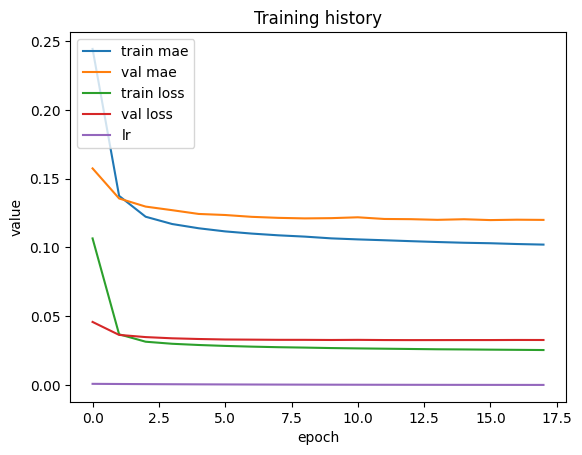

In [58]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['lr'])
plt.title('Training history')
plt.ylabel('value')
plt.xlabel('epoch')
plt.legend(['train mae', 'val mae', 'train loss', 'val loss', 'lr'], loc='upper left')
plt.show()

In [59]:
from tensorflow.keras.models import load_model

base_path = ''

model_folder = os.path.join(base_path, 'collaborative_filtering_model')

model = load_model(os.path.join(model_folder, 'model.h5'))

with open(os.path.join(model_folder, 'day_encoder.pkl'), 'rb') as f:
    day_encoder = pickle.load(f)

with open(os.path.join(model_folder, 'occasion_encoder.pkl'), 'rb') as f:
    occasion_encoder = pickle.load(f)

with open(os.path.join(model_folder, 'source_encoder.pkl'), 'rb') as f:
    source_encoder = pickle.load(f)

with open(os.path.join(model_folder, 'food_idx_map.pkl'), 'rb') as f:
    food_idx_map = pickle.load(f)

with open(os.path.join(model_folder, 'user_idx_map.pkl'), 'rb') as f:
    user_idx_map = pickle.load(f)

with open(os.path.join(model_folder, 'scaler.pkl'), 'rb') as f:
    scaler = pickle.load(f)

In [60]:
len(food_idx_map)

4512